In [1]:
import os
import numpy as np
import rasterio
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

print(" Libraries loaded.")


 Libraries loaded.


In [2]:
import subprocess
import os
import re

def get_least_used_gpu():
    """Find the GPU with the lowest memory usage using nvidia-smi."""
    try:
        output = subprocess.check_output(
            "nvidia-smi --query-gpu=memory.used,memory.total --format=csv,noheader,nounits",
            shell=True
        ).decode("utf-8").strip().split("\n")

        memory_usage = [list(map(int, re.findall(r"\d+", line))) for line in output]
        gpu_utilization = [used / total for used, total in memory_usage]

        best_gpu = gpu_utilization.index(min(gpu_utilization))
        return best_gpu
    except Exception as e:
        print(f" Error finding GPU: {e}")
        return None

#  Set the best GPU for XGBoost training
best_gpu = get_least_used_gpu()
if best_gpu is not None:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(best_gpu)
    print(f" Using GPU {best_gpu} for XGBoost (set via CUDA_VISIBLE_DEVICES)")
else:
    print(" Could not determine the best GPU. Default settings will be used.")


 Using GPU 2 for XGBoost (set via CUDA_VISIBLE_DEVICES)


In [3]:
# Define base directory where all .SAFE scenes are stored
base_dir = "/home/AD.IGD.FRAUNHOFER.DE/mdgolam/Cloud_masking/Data/"

# Sentinel-2 bands to load (8 spectral + 1 SCL)
band_ids = ["B02", "B03", "B04", "B05", "B06", "B07", "B11", "B12", "SCL"]

print(" Base directory and band list initialized.")


 Base directory and band list initialized.


In [4]:
def get_scene_paths(base_dir):
    return [os.path.join(base_dir, d) for d in os.listdir(base_dir) if d.endswith(".SAFE")]


In [5]:
def get_band_paths(scene_path):
    granule_path = os.path.join(scene_path, "GRANULE")
    if not os.path.exists(granule_path):
        return None, None

    granule_dirs = os.listdir(granule_path)
    if not granule_dirs:
        return None, None

    granule_subdir = os.path.join(granule_path, granule_dirs[0], "IMG_DATA")
    path_20 = os.path.join(granule_subdir, "R20m")
    path_60 = os.path.join(granule_subdir, "R60m")
    return path_20, path_60


In [6]:
def find_band_file(path, band_prefix, resolution):
    for f in os.listdir(path):
        if band_prefix in f and f.endswith(f"{resolution}.jp2"):
            return os.path.join(path, f)
    return None


In [7]:
def load_bands(path, band_ids, resolution, scale_factor=10000):
    bands = {}
    for band_id in band_ids:
        band_path = find_band_file(path, band_id, resolution)
        if not band_path:
            continue
        with rasterio.open(band_path) as src:
            band_data = src.read(1)
            if band_id != "SCL":
                band_data = band_data / scale_factor
            bands[band_id] = band_data
    return bands


In [8]:
def reshape_cube_to_2d(cube_3d):
    return cube_3d.reshape(cube_3d.shape[0], -1).T  # (H*W, 8)

def flatten_scl(scl_2d):
    return scl_2d.flatten()


In [9]:
def prepare_dataset_from_all_scenes(base_dir, band_ids):
    scenes = get_scene_paths(base_dir)
    X_all, y_all = [], []

    for scene_path in scenes:
        scene_name = os.path.basename(scene_path)
        print(f" Processing scene: {scene_name}")

        path_20, path_60 = get_band_paths(scene_path)
        if not path_20 or not path_60:
            print(f" Skipping scene {scene_name}")
            continue

        try:
            b20 = load_bands(path_20, band_ids, resolution="20m")
            b60 = load_bands(path_60, band_ids, resolution="60m")

            bands_20 = np.stack([b20[b] for b in band_ids if b != "SCL"])
            bands_60 = np.stack([b60[b] for b in band_ids if b != "SCL"])
            scl_20 = b20["SCL"]
            scl_60 = b60["SCL"]

            #  Print shapes before reshaping
            print(f" 20m cube shape: {bands_20.shape}")
            print(f" 60m cube shape: {bands_60.shape}")
            print(f" SCL 20m shape: {scl_20.shape}")
            print(f" SCL 60m shape: {scl_60.shape}")

            X_20 = reshape_cube_to_2d(bands_20)
            X_60 = reshape_cube_to_2d(bands_60)
            y_20 = flatten_scl(scl_20)
            y_60 = flatten_scl(scl_60)

            #  Print shapes after reshaping
            print(f" Reshaped 20m → X: {X_20.shape}, y: {y_20.shape}")
            print(f" Reshaped 60m → X: {X_60.shape}, y: {y_60.shape}")

            X_combined = np.concatenate([X_20, X_60], axis=0)
            y_combined = np.concatenate([y_20, y_60], axis=0)

            X_all.append(X_combined)
            y_all.append(y_combined)
        
        except Exception as e:
            print(f" Error with {scene_name}: {e}")

    X_full = np.concatenate(X_all, axis=0)
    y_full = np.concatenate(y_all, axis=0)
    
    print(f"\n Dataset ready: X={X_full.shape}, y={y_full.shape}")
    return X_full, y_full


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_xgboost(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

    model = xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=len(np.unique(y)),
        eval_metric="mlogloss",
        use_label_encoder=False,
        tree_method="hist",  # 'hist' is required, 'gpu_hist' is deprecated
        device='cuda',       # Ensures training AND prediction on GPU
        n_jobs=-1
    )

    print(" Training XGBoost...")
    model.fit(X_train, y_train)

    # Predict on training and testing sets
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    #  Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n Training Accuracy: {train_acc:.4f}")
    print(f" Test Accuracy: {acc:.4f}")

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

    print(" Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return model, y_test, y_pred, acc


In [11]:
X_data, y_data = prepare_dataset_from_all_scenes(base_dir, band_ids) #469 million pixels

 Processing scene: S2B_MSIL2A_20240922T101629_N0511_R065_T32UQE_20240922T144608.SAFE
 20m cube shape: (8, 5490, 5490)
 60m cube shape: (8, 1830, 1830)
 SCL 20m shape: (5490, 5490)
 SCL 60m shape: (1830, 1830)
 Reshaped 20m → X: (30140100, 8), y: (30140100,)
 Reshaped 60m → X: (3348900, 8), y: (3348900,)
 Processing scene: S2B_MSIL2A_20230928T101719_N0509_R065_T32UQE_20230928T145710.SAFE
 20m cube shape: (8, 5490, 5490)
 60m cube shape: (8, 1830, 1830)
 SCL 20m shape: (5490, 5490)
 SCL 60m shape: (1830, 1830)
 Reshaped 20m → X: (30140100, 8), y: (30140100,)
 Reshaped 60m → X: (3348900, 8), y: (3348900,)
 Processing scene: S2B_MSIL2A_20220903T101559_N0400_R065_T32UQE_20220903T131112.SAFE
 20m cube shape: (8, 5490, 5490)
 60m cube shape: (8, 1830, 1830)
 SCL 20m shape: (5490, 5490)
 SCL 60m shape: (1830, 1830)
 Reshaped 20m → X: (30140100, 8), y: (30140100,)
 Reshaped 60m → X: (3348900, 8), y: (3348900,)
 Processing scene: S2B_MSIL2A_20231127T102259_N0509_R065_T32UQE_20231127T115230.SAFE


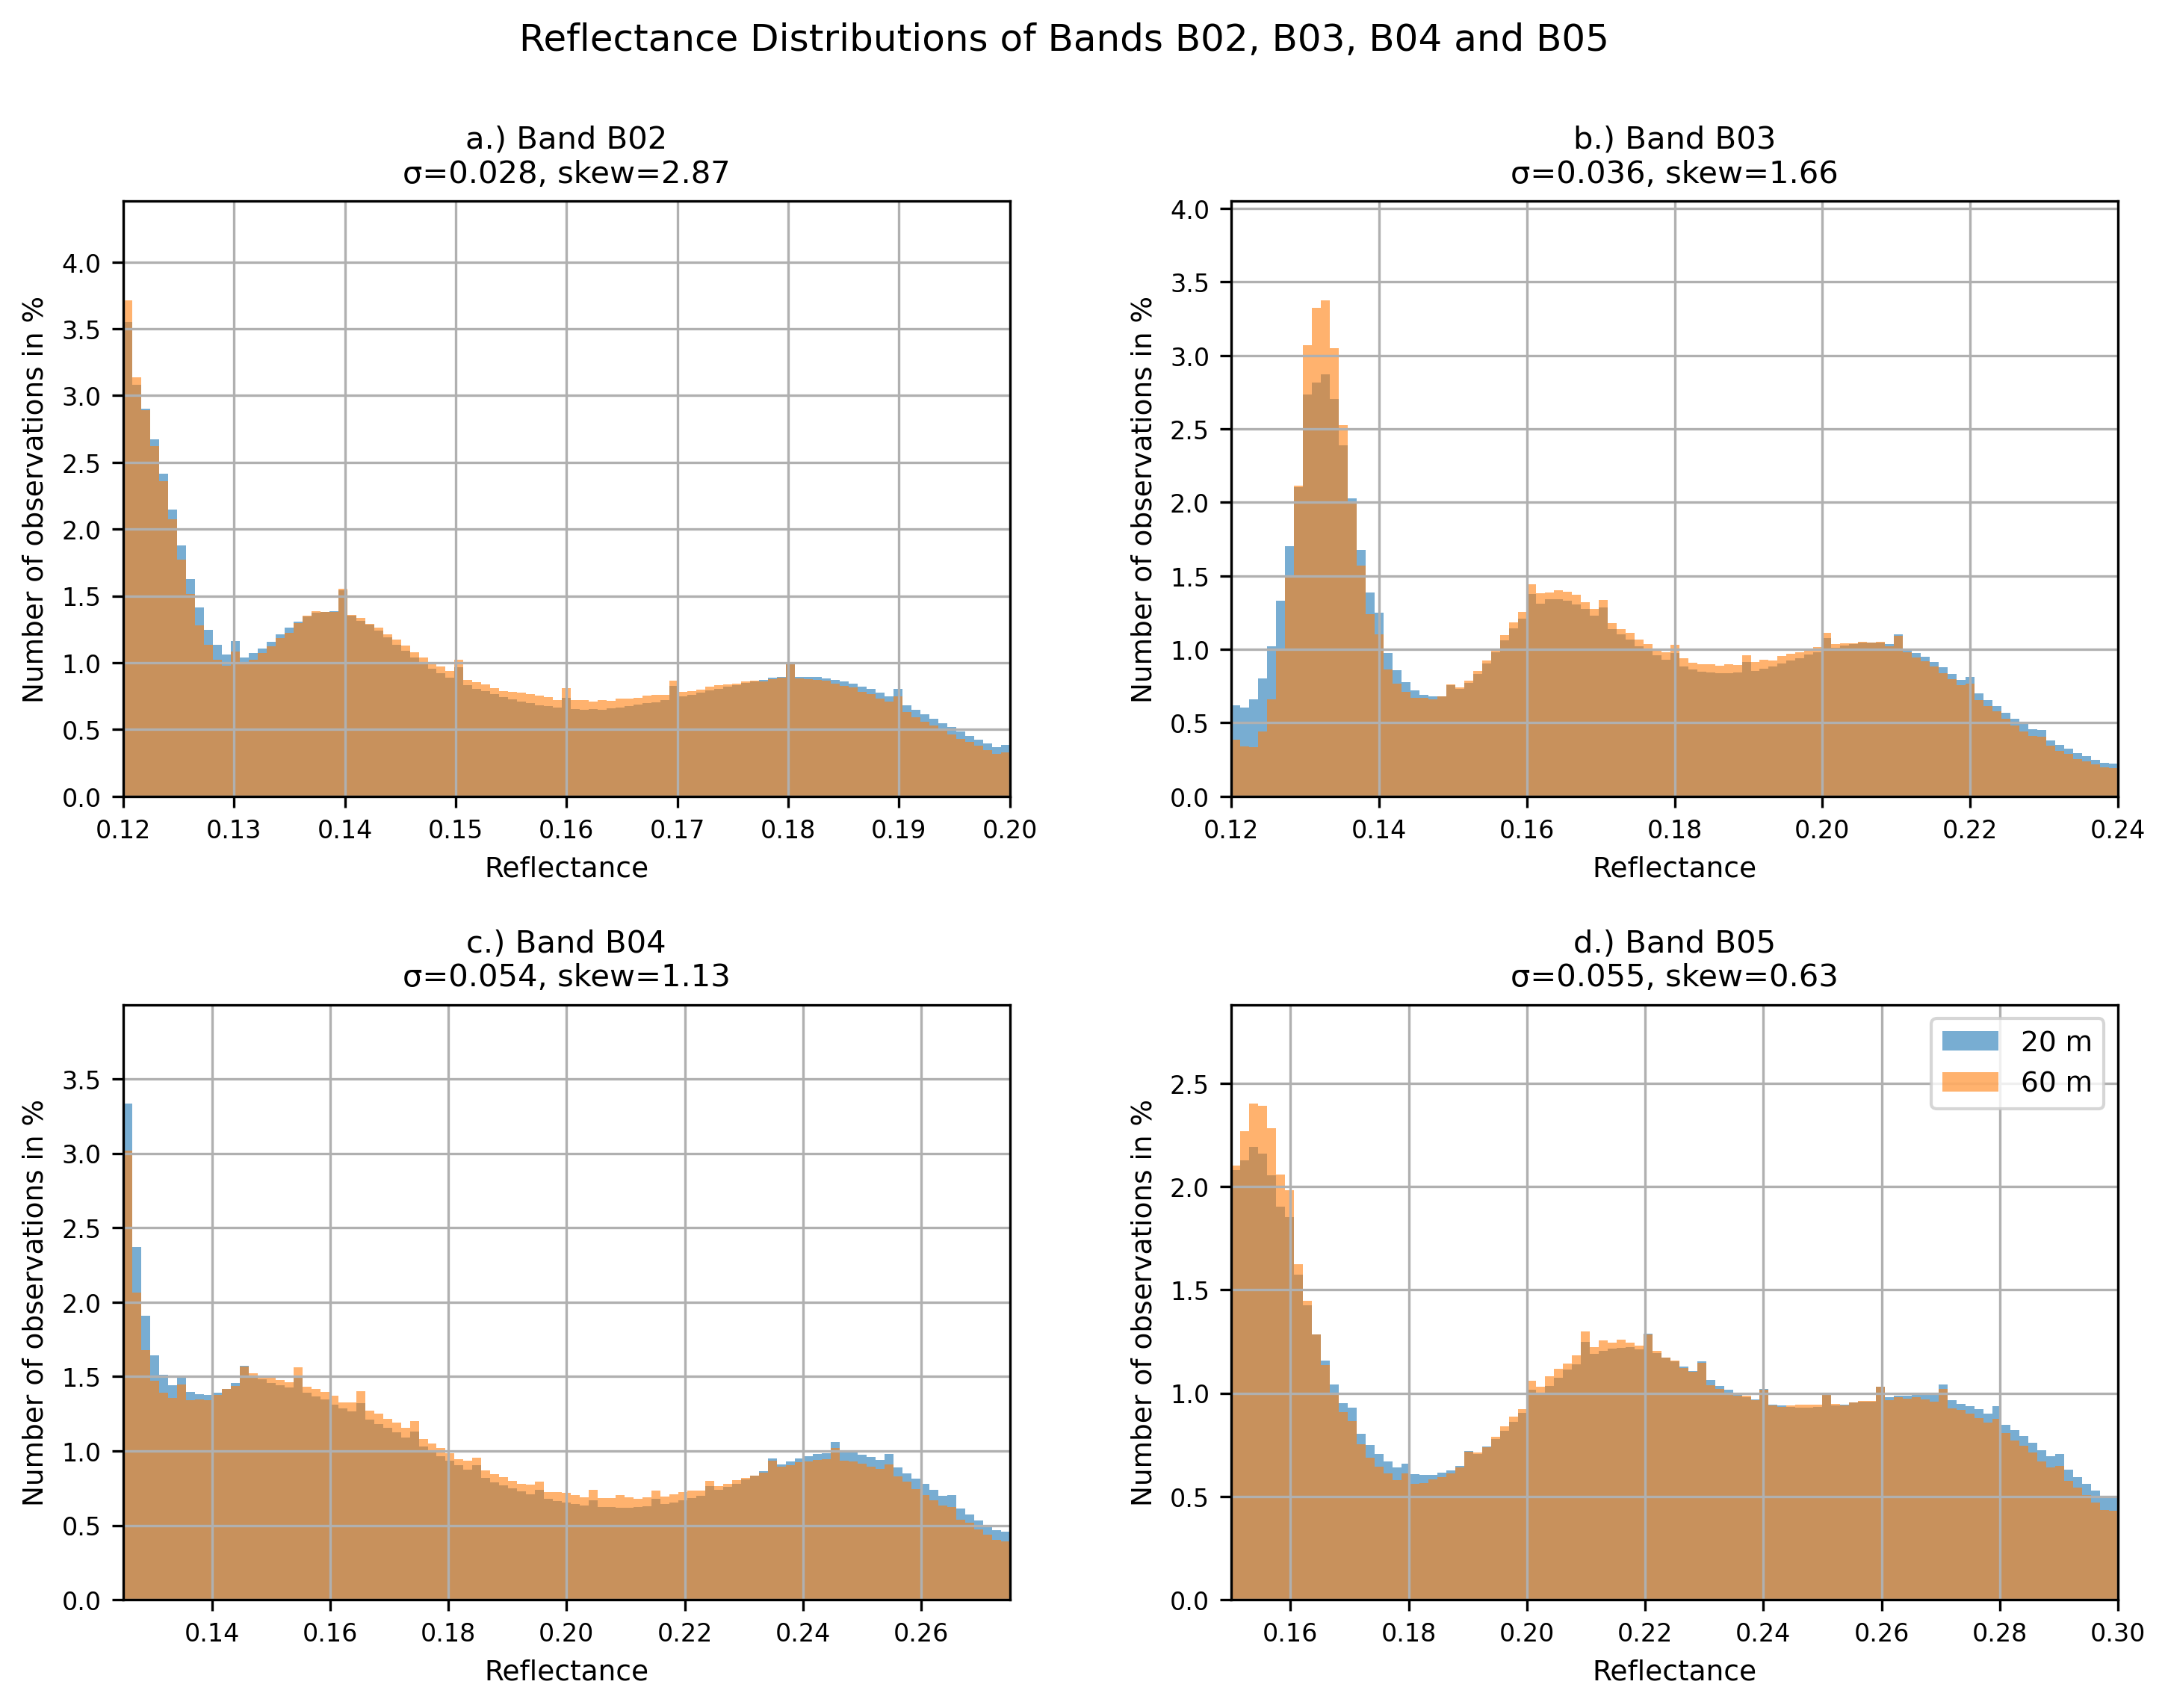

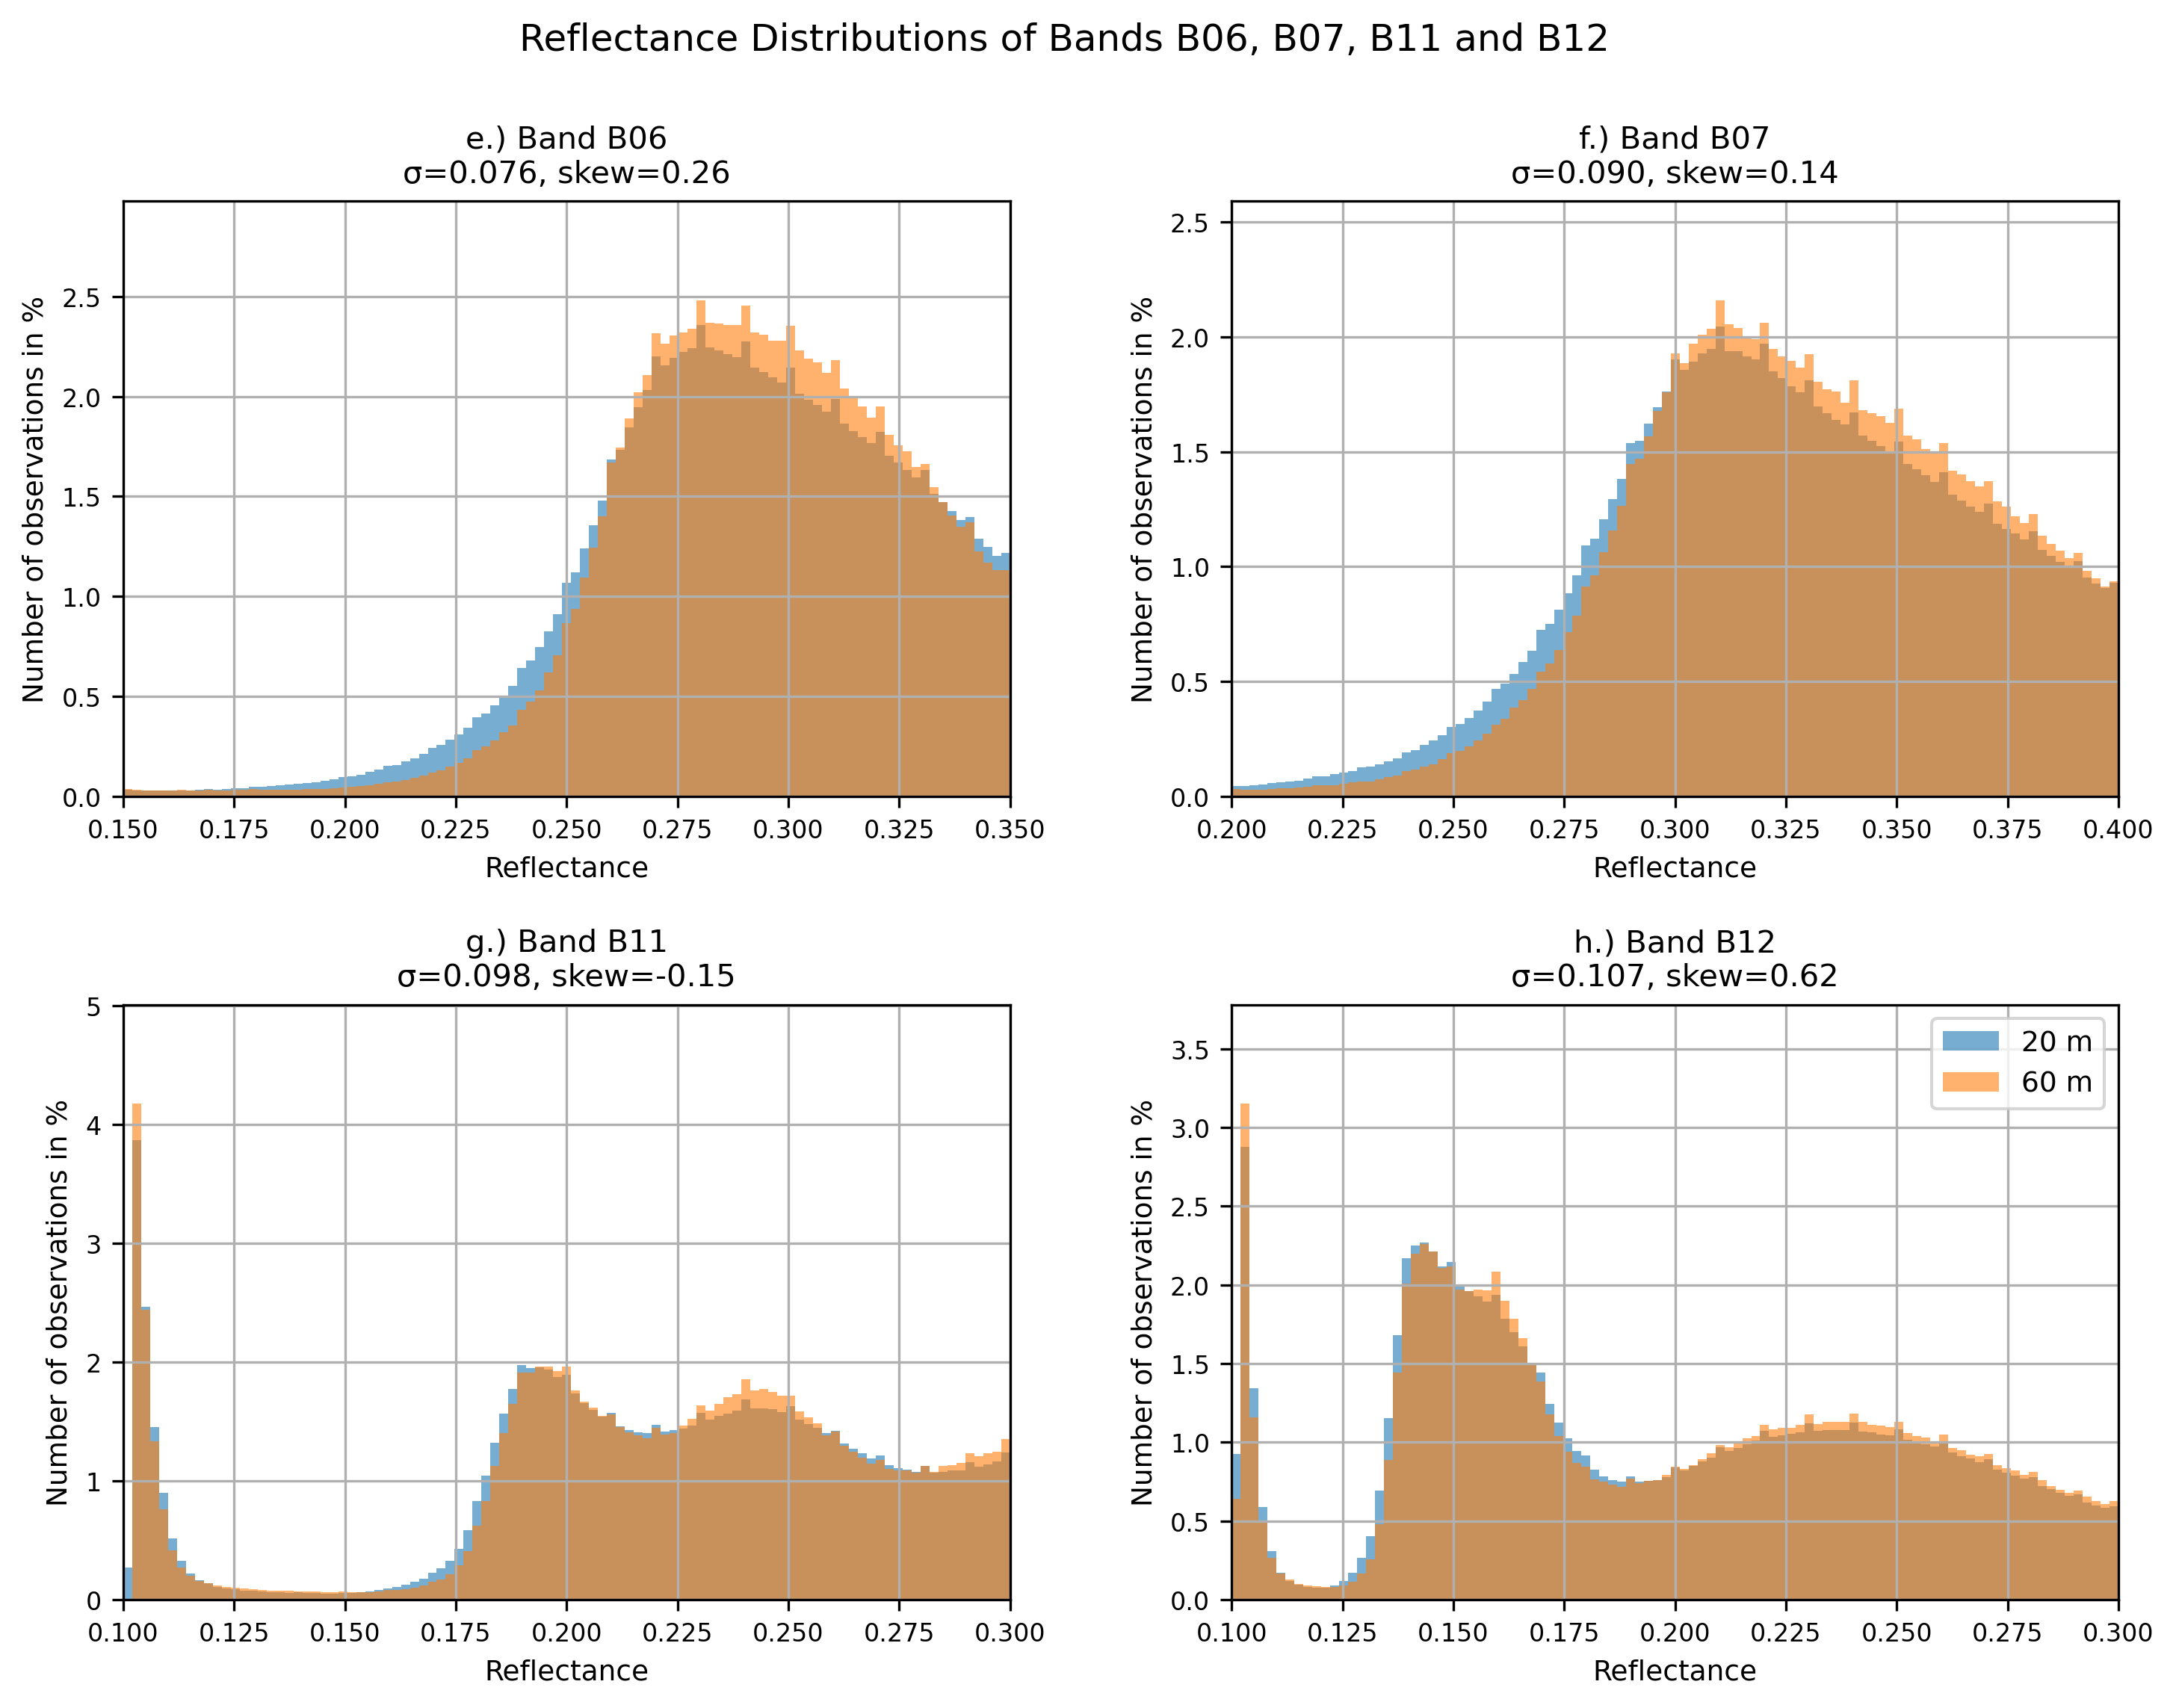

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

# Bands and layout grouping
bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B11", "B12"]
custom_ranges = {
    "B02": (0.12, 0.20), "B03": (0.12, 0.24),
    "B04": (0.125, 0.275), "B05": (0.15, 0.30),
    "B06": (0.15, 0.35), "B07": (0.20, 0.40),
    "B11": (0.10, 0.30), "B12": (0.10, 0.30)
}

# Utility: histogram → percent
def to_percentage(data, bins):
    hist, _ = np.histogram(data, bins=bins)
    return (hist / hist.sum()) * 100

# Load a single scene
scene_path = get_scene_paths(base_dir)[0]
p20, p60 = get_band_paths(scene_path)
b20 = load_bands(p20, bands, "20m")
b60 = load_bands(p60, bands, "60m")

# Titles for both pages
page_titles = [
    "Reflectance Distributions of Bands B02, B03, B04 and B05",
    "Reflectance Distributions of Bands B06, B07, B11 and B12"
]

# --- Plot in two 2×2 pages ---
for page in range(2):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
    
    for i in range(4):
        band_idx = page * 4 + i
        band = bands[band_idx]
        ax = axes[i // 2, i % 2]

        # Get reflectance and clean NaNs
        d20 = b20[band].flatten()
        d60 = b60[band].flatten()
        d20 = d20[~np.isnan(d20)]
        d60 = d60[~np.isnan(d60)]

        # Bin range and histogram
        xmin, xmax = custom_ranges[band]
        bins = np.linspace(xmin, xmax, 100)
        p20 = to_percentage(d20, bins)
        p60 = to_percentage(d60, bins)

        # Plot bars
        ax.bar(bins[:-1], p20, width=(bins[1] - bins[0]), color="tab:blue", alpha=0.6, label="20 m", align="edge")
        ax.bar(bins[:-1], p60, width=(bins[1] - bins[0]), color="tab:orange", alpha=0.6, label="60 m", align="edge")

        # Title with std and skew
        std_val = np.std(d20)
        skew_val = skew(d20)
        label_char = chr(97 + band_idx)  # a–h
        ax.set_title(f"{label_char}.) Band {band}\nσ={std_val:.3f}, skew={skew_val:.2f}", fontsize=10)

        # Axis formatting
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0, max(p20.max(), p60.max()) * 1.2)
        ax.set_xlabel("Reflectance", fontsize=9)
        ax.set_ylabel("Number of observations in %", fontsize=9)
        ax.tick_params(labelsize=8)
        ax.grid(True)

    # Add legend only once
    axes[1, 1].legend(loc="upper right", fontsize=9)

    # Layout and unified title
    fig.subplots_adjust(left=0.08, right=0.97, top=0.88, bottom=0.10, hspace=0.35, wspace=0.25)
    plt.suptitle(page_titles[page], fontsize=12)
    plt.show()


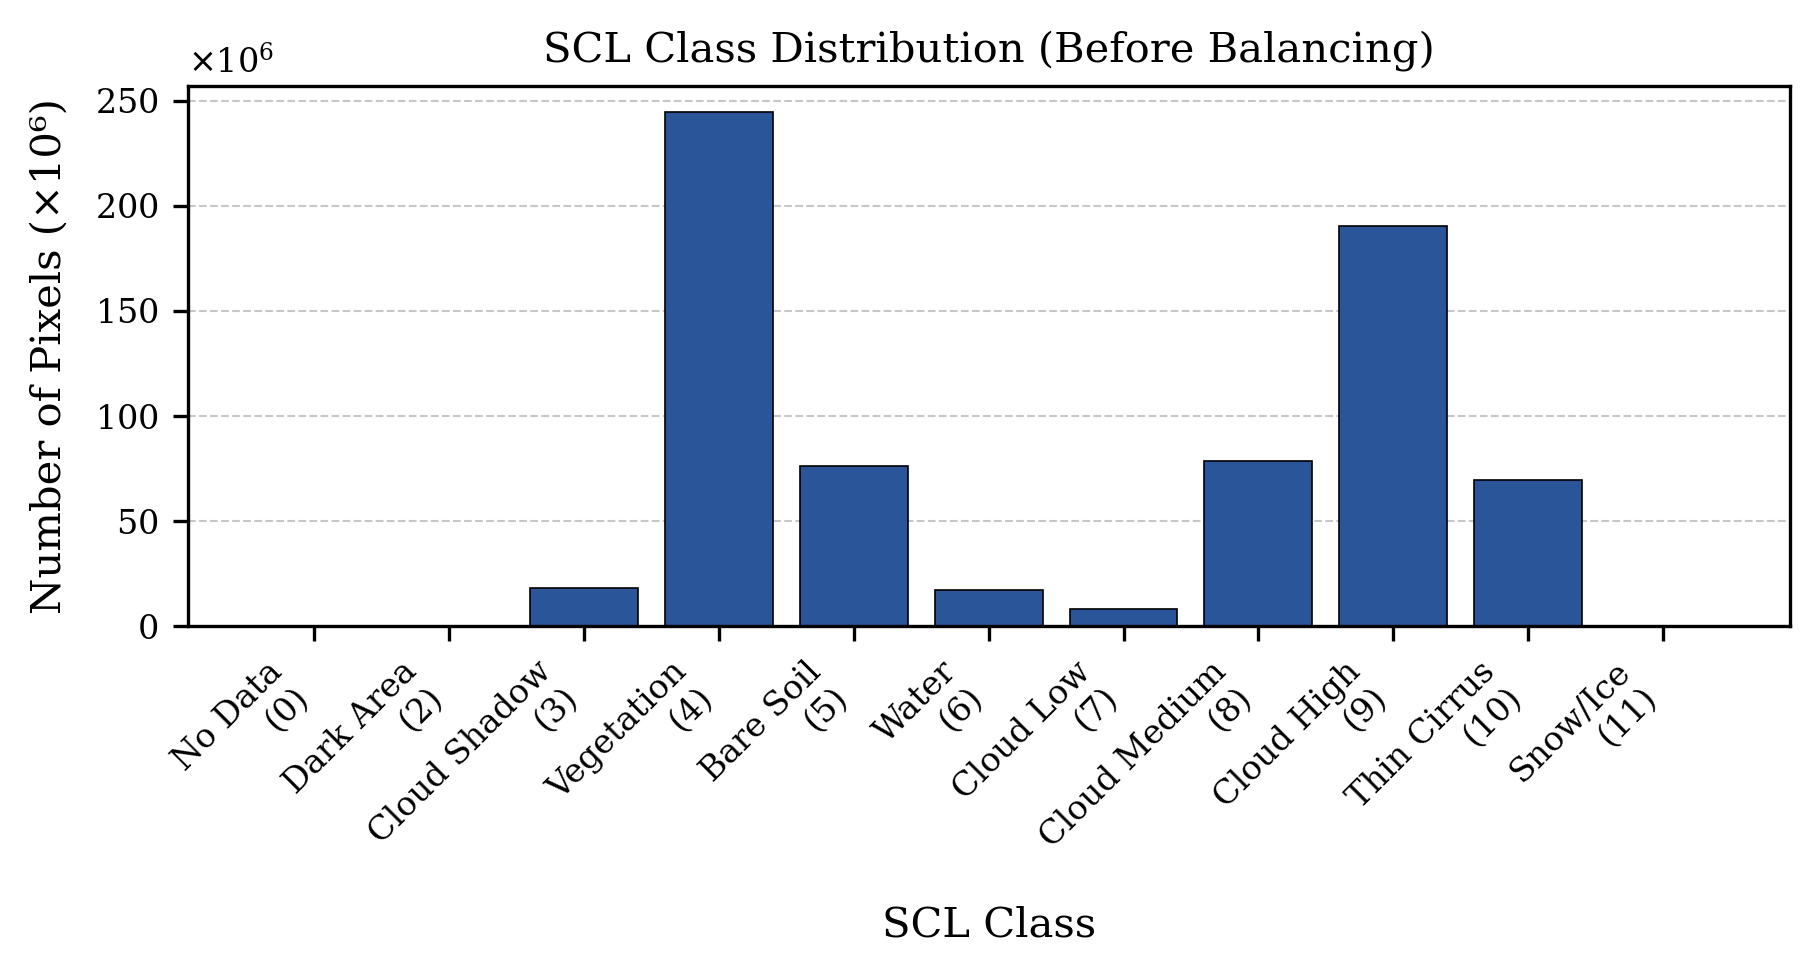

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


plt.rcParams.update({
    "font.family":       "serif",
    "font.size":         10,
    "axes.titlesize":    10,
    "axes.labelsize":    10,
    "xtick.labelsize":   8,
    "ytick.labelsize":   8,
    "figure.autolayout": False,
    "pdf.fonttype":      42,
    "ps.fonttype":       42
})

# Class label mapping
scl_mapping = {
    0: "No Data", 2: "Dark Area", 3: "Cloud Shadow",
    4: "Vegetation", 5: "Bare Soil", 6: "Water",
    7: "Cloud Low", 8: "Cloud Medium", 9: "Cloud High",
    10: "Thin Cirrus", 11: "Snow/Ice"
}


def plot_scl_distribution(y, title="SCL Class Distribution"):
    unique, counts = np.unique(y, return_counts=True)

    # Prepare labels
    class_names = [scl_mapping.get(c, f"Unknown ({c})") + f"\n({c})" for c in unique]

    # Create plot
    fig, ax = plt.subplots(figsize=(6, 3), dpi=300)
    ax.bar(class_names, counts, color="#2a5599", edgecolor="black", linewidth=0.4)

    # Format axes
    ax.set_xlabel("SCL Class", labelpad=6)
    ax.set_ylabel("Number of Pixels (×10⁶)", labelpad=6)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(6,6))

    # Style
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fig.subplots_adjust(left=0.10, right=0.99, top=0.90, bottom=0.30)

    # Title & show
    ax.set_title(title)
    plt.show()


plot_scl_distribution(y_data, title="SCL Class Distribution (Before Balancing)")


Balanced dataset shape: X=(48148961, 8), y=(48148961,)


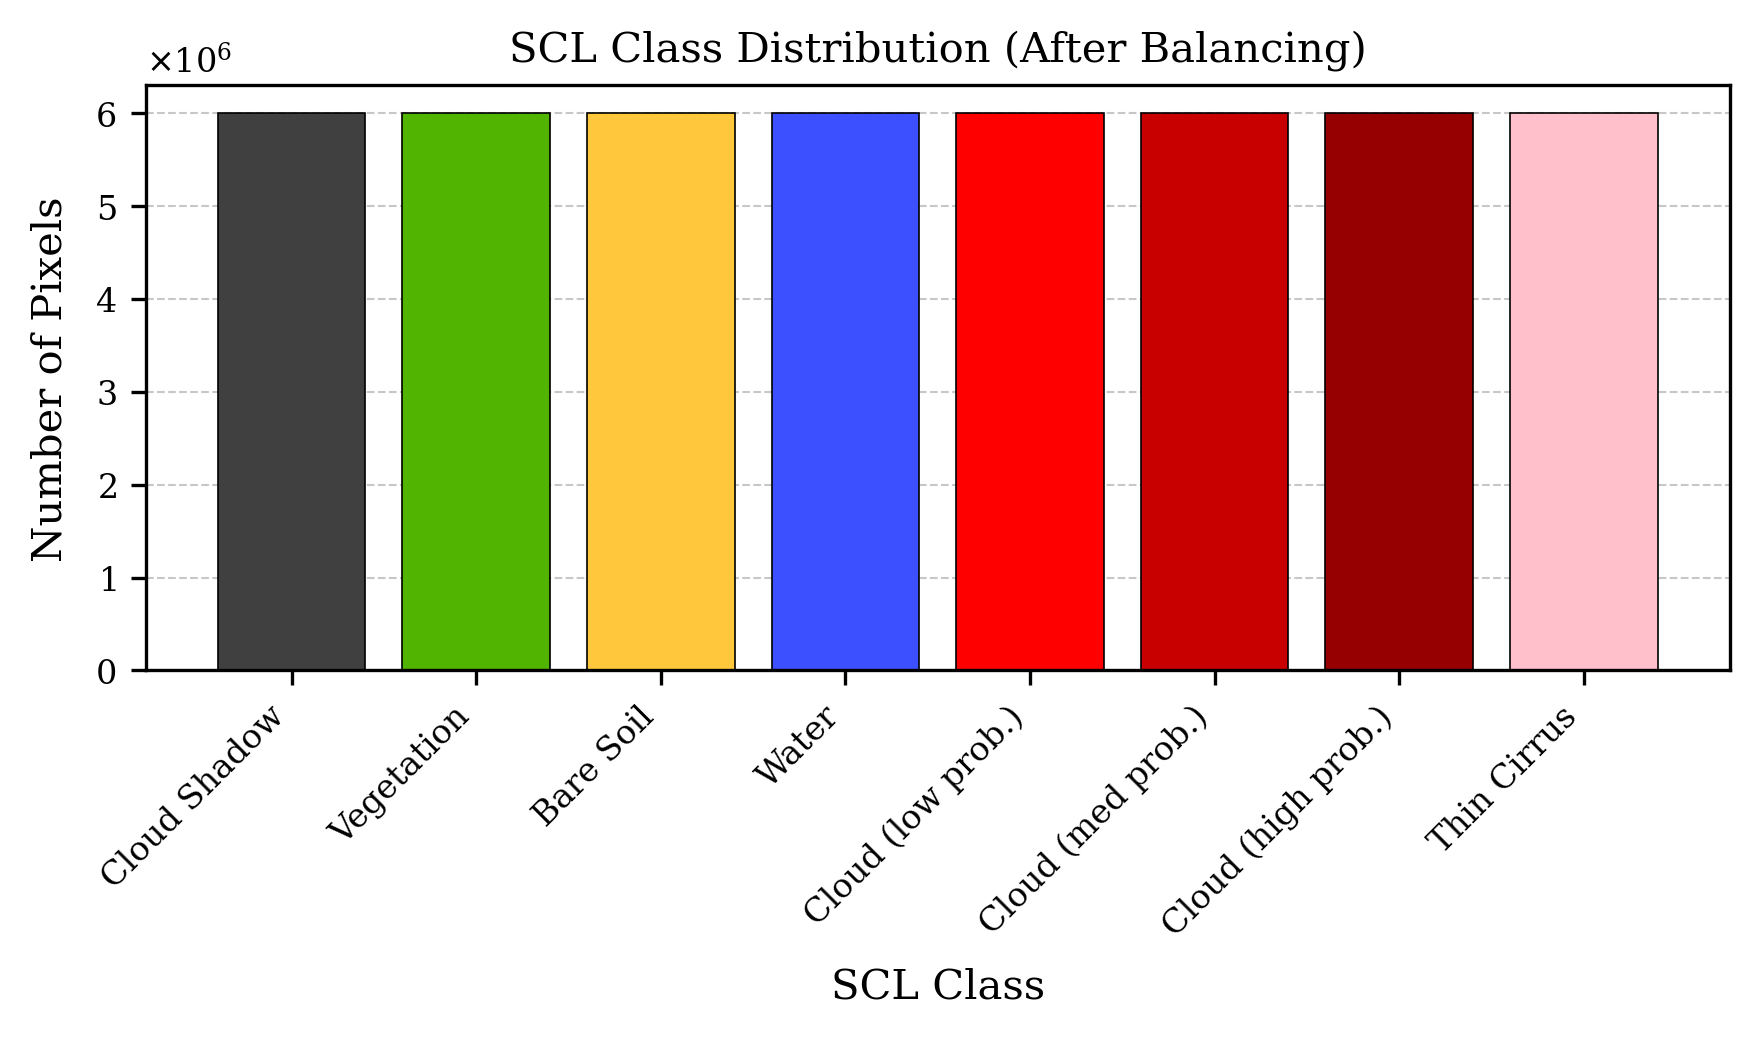

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


plt.rcParams.update({
    "font.family":       "serif",
    "font.size":         10,
    "axes.titlesize":    10,
    "axes.labelsize":    10,
    "xtick.labelsize":   8,
    "ytick.labelsize":   8,
    "figure.autolayout": False,
    "pdf.fonttype":      42,
    "ps.fonttype":       42
})

# Define balancing function
def balance_classes(X, y, threshold=6000000):
    X_balanced = []
    y_balanced = []
    
    for c in np.unique(y):
        idx = np.where(y == c)[0]
        if len(idx) > threshold:
            idx = np.random.choice(idx, threshold, replace=False)
        X_balanced.append(X[idx])
        y_balanced.append(y[idx])
    
    X_final = np.concatenate(X_balanced, axis=0)
    y_final = np.concatenate(y_balanced, axis=0)
    
    print(f"Balanced dataset shape: X={X_final.shape}, y={y_final.shape}")
    return X_final, y_final

# Apply function
X_bal, y_bal = balance_classes(X_data, y_data, threshold=6000000)

# 4. Define class mapping (only for valid classes: 3–10)
scl_mapping = {
    3: "Cloud Shadow",
    4: "Vegetation",
    5: "Bare Soil",
    6: "Water",
    7: "Cloud (low prob.)",
    8: "Cloud (med prob.)",
    9: "Cloud (high prob.)",
    10: "Thin Cirrus"
}
classes = np.arange(3, 11)
labels = [scl_mapping[c] for c in classes]
counts = [np.sum(y_bal == c) for c in classes]

# 5. Color palette (per SCL class)
palette_rgb = {
    3: (64, 64, 64),
    4: (80, 180, 0),
    5: (255, 200, 60),
    6: (60, 80, 255),
    7: (255, 0, 0),
    8: (200, 0, 0),
    9: (150, 0, 0),
    10: (255, 192, 203)
}
colors = [np.array(palette_rgb[c]) / 255 for c in classes]

# 6. Plot histogram
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

ax.bar(labels, counts, color=colors, edgecolor="black", linewidth=0.4)

ax.set_xlabel("SCL Class", labelpad=6)
ax.set_ylabel("Number of Pixels", labelpad=6)

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis="y", style="scientific", scilimits=(6,6))

ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.subplots_adjust(left=0.10, right=0.98, top=0.90, bottom=0.25)

plt.title("SCL Class Distribution (After Balancing)", fontsize=10)
plt.show()

Pixel Counts After Merging (Clouds → 8):
  Class 0 - Unknown (0)              : 42 pixels
  Class 2 - Unknown (2)              : 139,282 pixels
  Class 3 - Cloud Shadow             : 6,000,000 pixels
  Class 4 - Vegetation               : 6,000,000 pixels
  Class 5 - Bare Soil                : 6,000,000 pixels
  Class 6 - Water                    : 6,000,000 pixels
  Class 8 - Cloud (med prob.)        : 18,000,000 pixels
  Class 10 - Thin Cirrus              : 6,000,000 pixels
  Class 11 - Unknown (11)             : 9,637 pixels


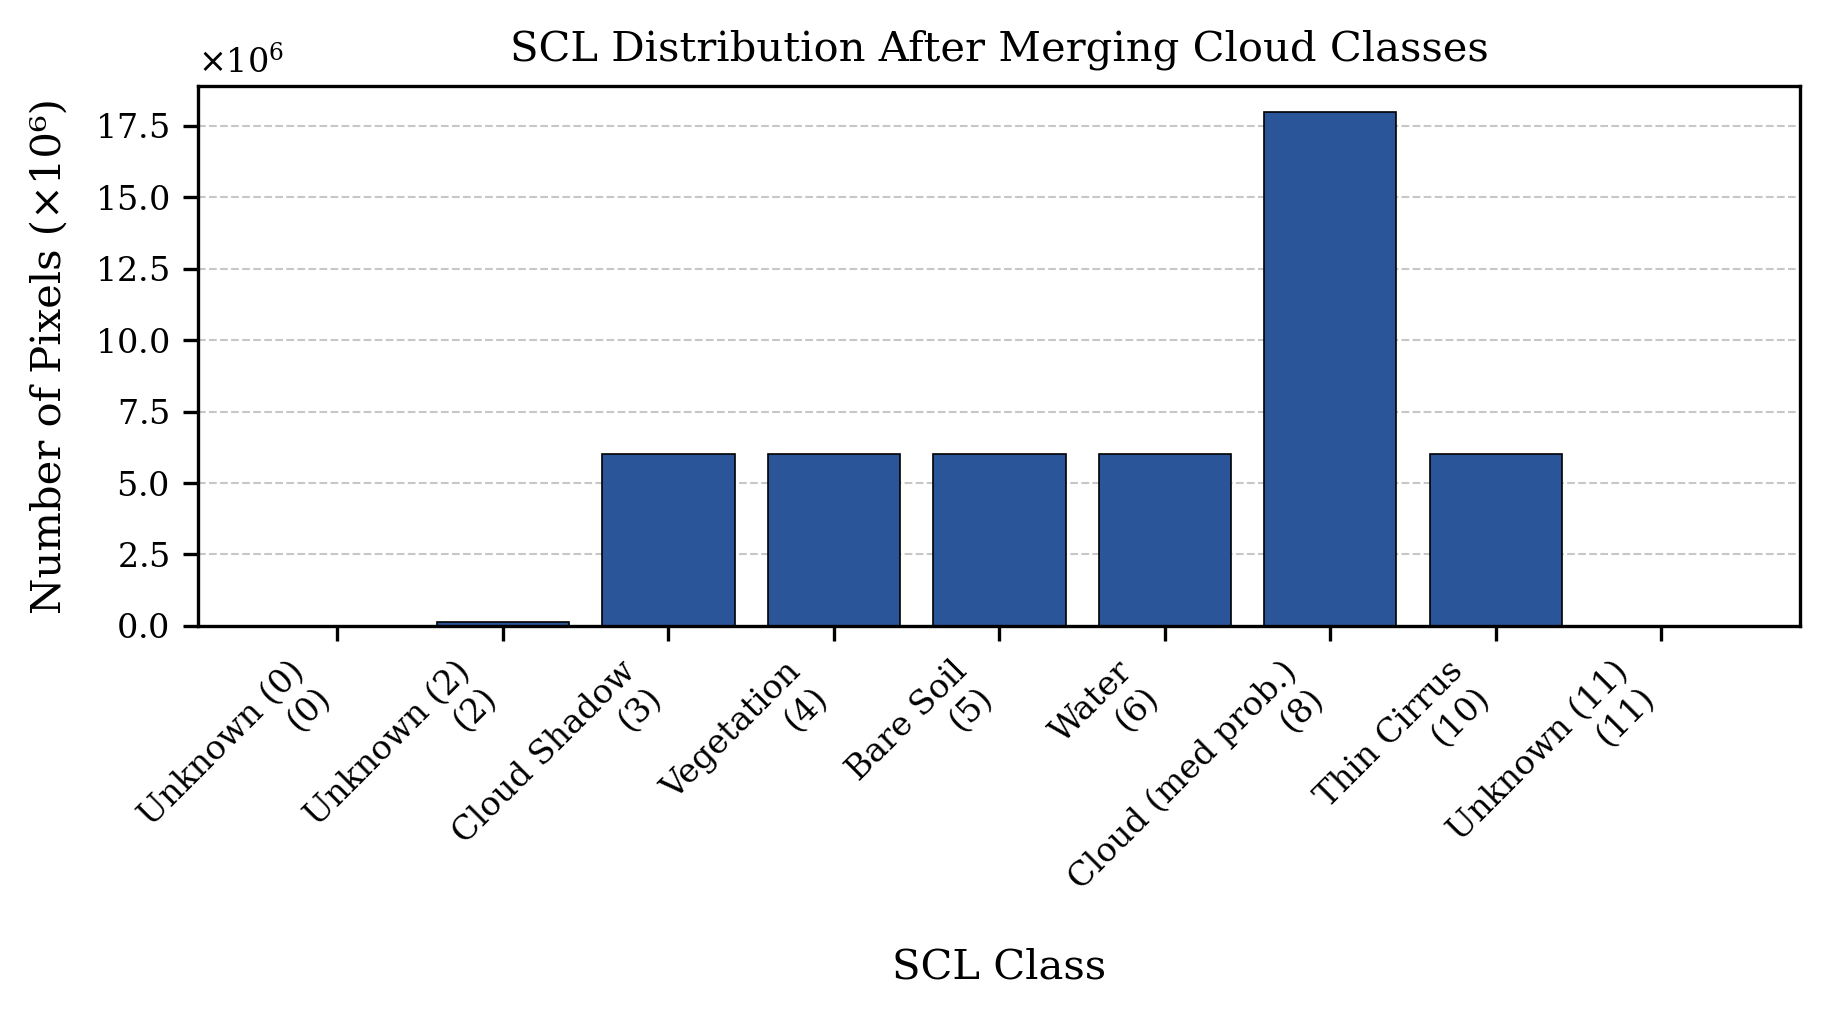

In [15]:
# Merge cloud-related classes (8, 9, 10) into class 8
y_bal_merged = np.copy(y_bal)
y_bal_merged[np.isin(y_bal_merged, [7, 9])] = 8

# Count and print number of pixels for each available class after merging
unique_classes, counts = np.unique(y_bal_merged, return_counts=True)
print("Pixel Counts After Merging (Clouds → 8):")
for cls, count in zip(unique_classes, counts):
    label = scl_mapping.get(cls, f"Unknown ({cls})")
    print(f"  Class {cls} - {label:25}: {count:,} pixels")

# Plot distribution
plot_scl_distribution(y_bal_merged, title="SCL Distribution After Merging Cloud Classes")


In [16]:
# Keep only valid classes after merging
valid_scl_merged = [3, 4, 5, 6, 8,10]
scl_remap_merged = {v: i for i, v in enumerate(valid_scl_merged)}  # 3→0, 4→1, ..., 8→5

#  Filter the dataset to only include valid SCL values
mask = np.isin(y_bal_merged, valid_scl_merged)
X_final = X_bal[mask]
y_final = y_bal_merged[mask]

#  Apply remapping
y_final_remapped = np.vectorize(scl_remap_merged.get)(y_final)

#  Confirm class labels
print(f" Final class labels after remapping: {np.unique(y_final_remapped)}")


 Final class labels after remapping: [0 1 2 3 4 5]


In [17]:
#knowing original labels
for original, new in scl_remap_merged.items():
    name = scl_mapping.get(original, f"Class {original}")
    print(f"Original {original} ({name}) → Remapped {new}")


Original 3 (Cloud Shadow) → Remapped 0
Original 4 (Vegetation) → Remapped 1
Original 5 (Bare Soil) → Remapped 2
Original 6 (Water) → Remapped 3
Original 8 (Cloud (med prob.)) → Remapped 4
Original 10 (Thin Cirrus) → Remapped 5


In [18]:
model, y_test, y_pred, acc = train_xgboost(X_final, y_final_remapped)

 Training XGBoost...


/home/AD.IGD.FRAUNHOFER.DE/mdgolam/mambaforge/envs/thesis_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:47:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/AD.IGD.FRAUNHOFER.DE/mdgolam/mambaforge/envs/thesis_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:48:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880369036/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



 Training Accuracy: 0.8194
 Test Accuracy: 0.8190

 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75   1200000
           1       0.79      0.87      0.83   1200000
           2       0.84      0.81      0.82   1200000
           3       0.92      0.93      0.93   1200000
           4       0.85      0.93      0.89   3600000
           5       0.62      0.42      0.50   1200000

    accuracy                           0.82   9600000
   macro avg       0.80      0.78      0.79   9600000
weighted avg       0.81      0.82      0.81   9600000

 Confusion Matrix:
[[ 887770   62508   15699   29251  159829   44943]
 [  34760 1049057   20729     148   10513   84793]
 [  57399   13005  972304    9354   88464   59474]
 [  35491     701    5602 1116342   38746    3118]
 [  86591   10626   30277   28762 3333064  110680]
 [  65927  189839  113962   24401  301638  504233]]


In [19]:
import joblib
joblib.dump(model, "xgboost_cloud_model_10.pkl")
print("Model saved as xgboost_cloud_model_10.pkl")


Model saved as xgboost_cloud_model_10.pkl



 Classification Report:
              precision    recall  f1-score   support

Cloud Shadow       0.76      0.74      0.75   1200000
  Vegetation       0.79      0.87      0.83   1200000
   Bare Soil       0.84      0.81      0.82   1200000
       Water       0.92      0.93      0.93   1200000
       Cloud       0.85      0.93      0.89   3600000
 Thin Cirrus       0.62      0.42      0.50   1200000

    accuracy                           0.82   9600000
   macro avg       0.80      0.78      0.79   9600000
weighted avg       0.81      0.82      0.81   9600000



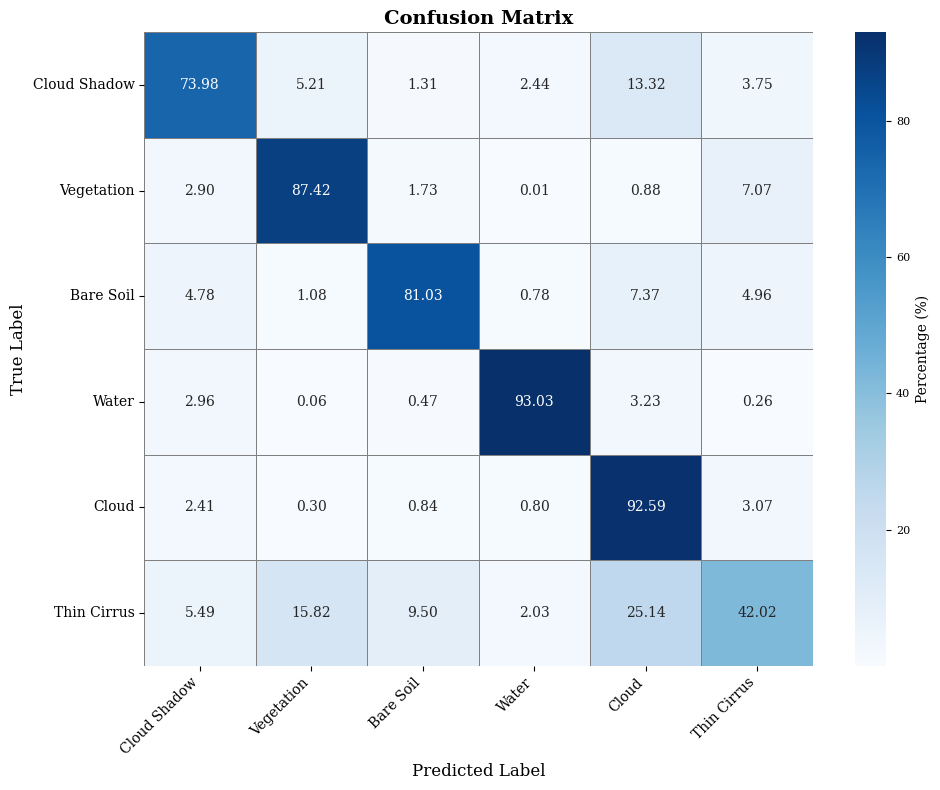

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Class labels (readable + numerical reference)
class_labels = [
    "Cloud Shadow",
    "Vegetation",
    "Bare Soil",
    "Water",
    "Cloud",
    "Thin Cirrus"
]

# Generate classification report with labels
print("\n Classification Report:")
print(classification_report(
    y_test, y_pred, 
    target_names=class_labels, 
    zero_division=0
))

# 2. Confusion Matrix — row-normalized (in percentage)
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# 3. Plot confusion matrix with % labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pct, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5, linecolor='gray',
            cbar_kws={"label": "Percentage (%)"})

plt.title("Confusion Matrix", fontsize=14, weight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


In [21]:
import os
import glob
import rasterio
import numpy as np
import joblib
import xgboost as xgb
from rasterio.enums import Resampling

# --- Setup ---
base_dir = "/home/AD.IGD.FRAUNHOFER.DE/mdgolam/Cloud_masking/Data"
scene_name = "S2B_MSIL2A_20220804T101559_N0400_R065_T32UQE_20220804T130854.SAFE"
scene_path = os.path.join(base_dir, scene_name)

bands_10m = ['B02', 'B03', 'B04']
bands_20m = ['B05', 'B06', 'B07', 'B11', 'B12']
valid_scl_merged = [3, 4, 5, 6, 8, 10]  # after merging 7, 9 → 8
scl_remap_merged = {3: 0, 4: 1, 5: 2, 6: 3, 8: 4, 10: 5}

# --- Band path helpers ---
def get_band_path_10m(scene_path):
    granule_path = os.path.join(scene_path, "GRANULE")
    granule_dirs = os.listdir(granule_path)
    return os.path.join(granule_path, granule_dirs[0], "IMG_DATA", "R10m")

def get_band_path_20m(scene_path):
    granule_path = os.path.join(scene_path, "GRANULE")
    granule_dirs = os.listdir(granule_path)
    return os.path.join(granule_path, granule_dirs[0], "IMG_DATA", "R20m")

# --- Process the single scene ---
X_all = []
y_all = []

path_10 = get_band_path_10m(scene_path)
path_20 = get_band_path_20m(scene_path)

# --- Load 10m bands ---
native_10m = []
for band in bands_10m:
    pattern = os.path.join(path_10, f'*_{band}_10m.jp2')
    matches = glob.glob(pattern)
    if not matches:
        raise FileNotFoundError(f"Missing 10m band {band} in {path_10}")
    with rasterio.open(matches[0]) as src:
        data = src.read(1)
        native_10m.append(data)
        ref_shape = (src.height, src.width)
        ref_transform = src.transform
        ref_crs = src.crs

native_10m_stack = np.stack(native_10m)

# --- Load and resample 20m bands ---
resampled_20m = []
for band in bands_20m:
    pattern = os.path.join(path_20, f'*_{band}_20m.jp2')
    matches = glob.glob(pattern)
    if not matches:
        raise FileNotFoundError(f"Missing 20m band {band} in {path_20}")
    with rasterio.open(matches[0]) as src:
        data = src.read(
            out_shape=(1, ref_shape[0], ref_shape[1]),
            resampling=Resampling.bilinear
        )[0]
        resampled_20m.append(data)

resampled_20m_stack = np.stack(resampled_20m)
full_stack = np.concatenate((native_10m_stack, resampled_20m_stack), axis=0)

# --- Load and manually corrected SCL ---
scl_pattern = os.path.join(path_20, '*SCL_20m.jp2')
matches = glob.glob(scl_pattern)
if not matches:
    raise FileNotFoundError(f"SCL mask not found in {path_20}")
scl_path = matches[0]
with rasterio.open(scl_path) as src:
    scl_10m = src.read(
        out_shape=(1, ref_shape[0], ref_shape[1]),
        resampling=Resampling.nearest
    )[0]

# Merge SCL classes
scl_10m[np.isin(scl_10m, [7, 9])] = 8

# Filter valid pixels
mask = np.isin(scl_10m, valid_scl_merged)
scl_filtered = scl_10m[mask]
scl_remapped = np.vectorize(scl_remap_merged.get)(scl_filtered)

# Create input for prediction
X_masked = full_stack.reshape(8, -1).T[mask.flatten()]
X_stage2 = X_masked / 10000.0
y_stage2 = scl_remapped

print("X_stage2 shape:", X_stage2.shape)
print("y_stage2 shape:", y_stage2.shape)

# --- Predict using trained model ---
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
model = joblib.load("xgboost_cloud_model.pkl")
booster = model.get_booster()

batch_size = 1_000_000
n_samples = X_stage2.shape[0]
predictions = []

print(f" Starting prediction for {n_samples:,} samples...")

for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    X_batch = X_stage2[start:end]
    dmatrix = xgb.DMatrix(X_batch)
    y_batch_pred = booster.predict(dmatrix)
    predictions.append(y_batch_pred)

y_pred_stage2 = np.concatenate(predictions).astype(int)

print("Prediction done.")
print("y_pred_stage2 shape:", y_pred_stage2.shape)


X_stage2 shape: (120545664, 8)
y_stage2 shape: (120545664,)
 Starting prediction for 120,545,664 samples...
Prediction done.
y_pred_stage2 shape: (120545664,)



 Classification Report:
              precision    recall  f1-score   support

Cloud Shadow       0.15      0.82      0.25    444808
  Vegetation       0.87      0.90      0.89  43631248
   Bare Soil       0.80      0.94      0.86  25536844
       Water       0.78      0.96      0.86   3468072
       Cloud       0.86      0.97      0.91  21770280
 Thin Cirrus       0.79      0.42      0.55  25694412

    accuracy                           0.82 120545664
   macro avg       0.71      0.84      0.72 120545664
weighted avg       0.83      0.82      0.81 120545664



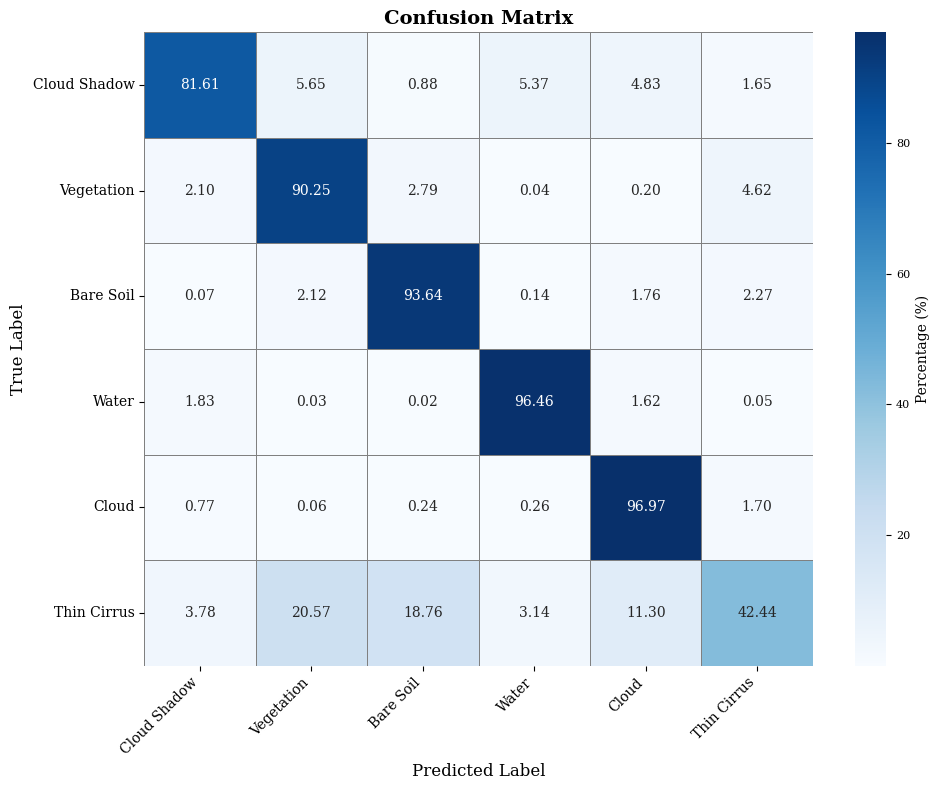

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import rasterio
from rasterio.enums import Resampling


with rasterio.open(scl_path) as src:
    scl_10m_eval = src.read(
        out_shape=(1, ref_shape[0], ref_shape[1]),
        resampling=Resampling.nearest
    )[0]


# Merge SCL 7 and 9 into 8

scl_10m_eval[np.isin(scl_10m_eval, [7, 9])] = 8


# Apply same valid mask & remap SCL

valid_mask_eval = np.isin(scl_10m_eval, valid_scl_merged)
scl_filtered_eval = scl_10m_eval[valid_mask_eval]
y_true = np.vectorize(scl_remap_merged.get)(scl_filtered_eval)


assert y_true.shape == y_pred_stage2.shape, "Mismatch in shape between true and predicted labels!"

# Generate Classification Report on after inference

class_labels = [
    "Cloud Shadow",  # 3
    "Vegetation",    # 4
    "Bare Soil",     # 5
    "Water",         # 6
    "Cloud",         # 7,8,9 → 8
    "Thin Cirrus"    # 10
]

print("\n Classification Report:")
print(classification_report(
    y_true, y_pred_stage2, 
    target_names=class_labels, 
    zero_division=0
))


# Confusion Matrix Visualization

cm = confusion_matrix(y_true, y_pred_stage2)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_pct, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5, linecolor='gray',
            cbar_kws={"label": "Percentage (%)"})

plt.title("Confusion Matrix", fontsize=14, weight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


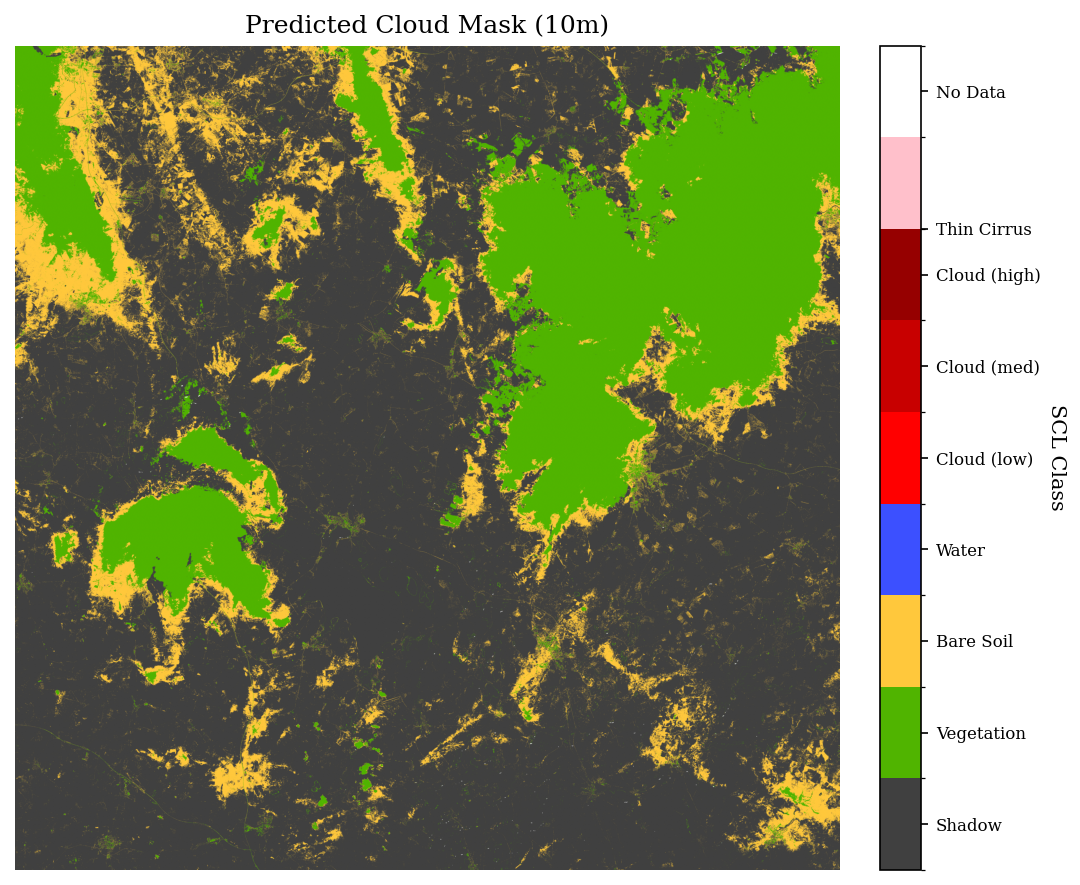

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Step 1: Create Empty Prediction Image ---
# All invalid pixels will be set to 255 (no data class)
prediction_image = np.full(ref_shape, 255, dtype=np.uint8)

# Flatten to assign valid predictions
prediction_flat = prediction_image.flatten()
prediction_flat[mask.flatten()] = y_pred_stage2
prediction_image = prediction_flat.reshape(ref_shape)

# --- Step 2: Define color map (SCL classes 3–10 + 255 for no data) ---
scl_cmap = ListedColormap([
    "#404040",  # 3: Cloud Shadow
    "#50b400",  # 4: Vegetation
    "#ffc83c",  # 5: Bare Soil
    "#3c50ff",  # 6: Water
    "#ff0000",  # 7: Cloud (low prob.)
    "#c80000",  # 8: Cloud (med prob.)
    "#960000",  # 9: Cloud (high prob.)
    "#ffc0cb",  # 10: Thin Cirrus
    "#ffffff"   # 255: No Data
])

scl_classes = [3, 4, 5, 6, 7, 8, 9, 10, 255]
boundaries = np.array(scl_classes + [256]) - 0.5
norm = BoundaryNorm(boundaries, scl_cmap.N)

# --- Step 3: Plot the prediction mask ---
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
im = ax.imshow(prediction_image, cmap=scl_cmap, norm=norm)

# Add labeled colorbar
cbar = plt.colorbar(im, ticks=scl_classes, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels([
    "Shadow", "Vegetation", "Bare Soil", "Water",
    "Cloud (low)", "Cloud (med)", "Cloud (high)",
    "Thin Cirrus", "No Data"
])
cbar.set_label("SCL Class", rotation=270, labelpad=12)

# Final touch
ax.set_title("Predicted Cloud Mask (10m)", fontsize=12)
ax.axis("off")
plt.tight_layout()
plt.show()
